In [1]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset,Dataset, DataLoader,random_split
from PIL import Image  
import os   
from torchvision import transforms
import numpy as np
import cv2
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

class MyData(TensorDataset):
    def __init__(self, root_dir, data_dir ,mask_dir):
        self.root_dir = root_dir
        self.data_dir = data_dir
        self.mask_dir = mask_dir
       
        path = os.path.join(self.root_dir, self.data_dir)
        
        self.img_list = os.listdir(path)  
 
    def __getitem__(self, idx):

        img_name = self.img_list[idx]

        img_item_path = os.path.join(self.root_dir, self.data_dir, img_name)
        mask_item_path = os.path.join(self.root_dir, self.mask_dir, img_name)

        img = Image.open(img_item_path)
        mask = Image.open(mask_item_path)     
        mask = torch.tensor(np.array(mask),dtype=torch.long).unsqueeze(0)
        trans_totensor = transforms.ToTensor() 
        trans_resize = transforms.Resize((224,224))
        img = trans_resize(trans_totensor(img)*50) 
        mask = trans_resize(mask).squeeze(0)
        return img,mask
 
    def __len__(self):
        return len(self.img_list)
 
 
r_dir = "weizmann_horse_db"
horse_dir = "horse"
mask_dir = "mask"
horse_dataset = MyData(r_dir, horse_dir,mask_dir)
train_len=int(horse_dataset.__len__()*0.85)
test_len=horse_dataset.__len__()-train_len
train_data,test_data=random_split(horse_dataset,[train_len,test_len])
train_data[0][0].shape,#sum(sum(train_data[0][0]))

(torch.Size([3, 224, 224]),)

In [2]:
train_loader = DataLoader(dataset=train_data, batch_size=5, shuffle=True, num_workers=0, drop_last=True)
test_loader = DataLoader(dataset=test_data, batch_size=5, shuffle=False, num_workers=0, drop_last=False)


In [3]:
""" Parts of the U-Net model """

import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


In [4]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits


In [5]:
def get_miou(pre_pic, real_pic):
    miou = 0
    pre_pic = torch.argmax(pre_pic, 1)
    batch, width, height = pre_pic.shape
    for i in range(batch):
        predict = pre_pic[i]
        mask = real_pic[i]
        union = torch.logical_or(predict, mask).sum()
        inter = ((predict + mask) == 2).sum()
        if union < 1e-5:
            return 0
        miou += inter / union
    return miou / batch


def get_boundary(pic, is_mask):
    if not is_mask:
        pic = torch.argmax(pic, 1).cpu().numpy().astype('float64')
    else:
        pic = pic.cpu().numpy()
    batch, width, height = pic.shape
    new_pic = np.zeros([batch, width + 2, height + 2])
    mask_erode = np.zeros([batch, width, height])
    dil = int(round(0.02 * np.sqrt(width**2 + height**2)))
    if dil < 1:
        dil = 1
    for i in range(batch):
        new_pic[i] = cv2.copyMakeBorder(pic[i],
                                        1,
                                        1,
                                        1,
                                        1,
                                        cv2.BORDER_CONSTANT,
                                        value=0)
    kernel = np.ones((3, 3), dtype=np.uint8)
    for j in range(batch):
        pic_erode = cv2.erode(new_pic[j], kernel, iterations=dil)
        mask_erode[j] = pic_erode[1:width + 1, 1:height + 1]
    return torch.from_numpy(pic - mask_erode)


def get_biou(pre_pic, real_pic):
    inter = 0
    union = 0
    pre_pic = get_boundary(pre_pic, is_mask=False)
    real_pic = get_boundary(real_pic, is_mask=True)
    batch, width, height = pre_pic.shape
    for i in range(batch):
        predict = pre_pic[i]
        mask = real_pic[i]
        inter += ((predict * mask) > 0).sum()
        union += ((predict + mask) > 0).sum()
    if union < 1:
        return 0
    biou = (inter / union)
    return biou

In [6]:
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from tqdm import tqdm

epochs=30
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
lr=1e-5
model=UNet(3,2).to(device)
#model.load_state_dict(torch.load('m.pth'))
loss=nn.CrossEntropyLoss()
#optimizer=optim.Adam(model.parameters(),lr=lr)
optimizer=optim.RMSprop(model.parameters(), lr=lr, weight_decay=1e-8, momentum=0.9)
miou,biou=[],[]
tmiou,tbiou=[],[]
for epoch in range(epochs):
    m,b=[],[]
    tm,tb=[],[]
    for index,(image,label) in enumerate(train_loader,1):
        total_loss=[]
        torch.cuda.empty_cache()
        image,label=image.to(device),label.to(device)
        optimizer.zero_grad()
        y=model(image)
        #print(y.shape,label.shape)
        l=loss(y,label)
        total_loss.append(l)
        l.backward()
        optimizer.step()
        m.append(get_miou(y,label).cpu().detach())
        b.append(get_biou(y,label).cpu().detach())
    miou.append(sum(m)/len(m))
    biou.append(sum(b)/len(b))
    if epoch>10:
        torch.save(model.state_dict(),'UNet'+str(epoch)+'.pth')
    total_loss=sum(total_loss)
    print('epoch:',epoch+1,'loss:',total_loss)
    with torch.no_grad():
        for timage,tlabel in test_loader:
            timage,tlabel=timage.to(device),tlabel.to(device)
            ty=model(timage)
            tm.append(get_miou(ty,tlabel).cpu().detach())
            tb.append(get_biou(ty,tlabel).cpu().detach())
        tmiou.append(sum(tm)/len(tm))
        tbiou.append(sum(tb)/len(tb))




epoch: 1 loss: tensor(0.3450, device='cuda:0', grad_fn=<AddBackward0>)
epoch: 2 loss: tensor(0.2626, device='cuda:0', grad_fn=<AddBackward0>)
epoch: 3 loss: tensor(0.2218, device='cuda:0', grad_fn=<AddBackward0>)
epoch: 4 loss: tensor(0.2490, device='cuda:0', grad_fn=<AddBackward0>)
epoch: 5 loss: tensor(0.1353, device='cuda:0', grad_fn=<AddBackward0>)
epoch: 6 loss: tensor(0.1850, device='cuda:0', grad_fn=<AddBackward0>)
epoch: 7 loss: tensor(0.1249, device='cuda:0', grad_fn=<AddBackward0>)
epoch: 8 loss: tensor(0.1344, device='cuda:0', grad_fn=<AddBackward0>)
epoch: 9 loss: tensor(0.0931, device='cuda:0', grad_fn=<AddBackward0>)
epoch: 10 loss: tensor(0.1165, device='cuda:0', grad_fn=<AddBackward0>)
epoch: 11 loss: tensor(0.0890, device='cuda:0', grad_fn=<AddBackward0>)
epoch: 12 loss: tensor(0.0904, device='cuda:0', grad_fn=<AddBackward0>)
epoch: 13 loss: tensor(0.0804, device='cuda:0', grad_fn=<AddBackward0>)
epoch: 14 loss: tensor(0.0622, device='cuda:0', grad_fn=<AddBackward0>)
e

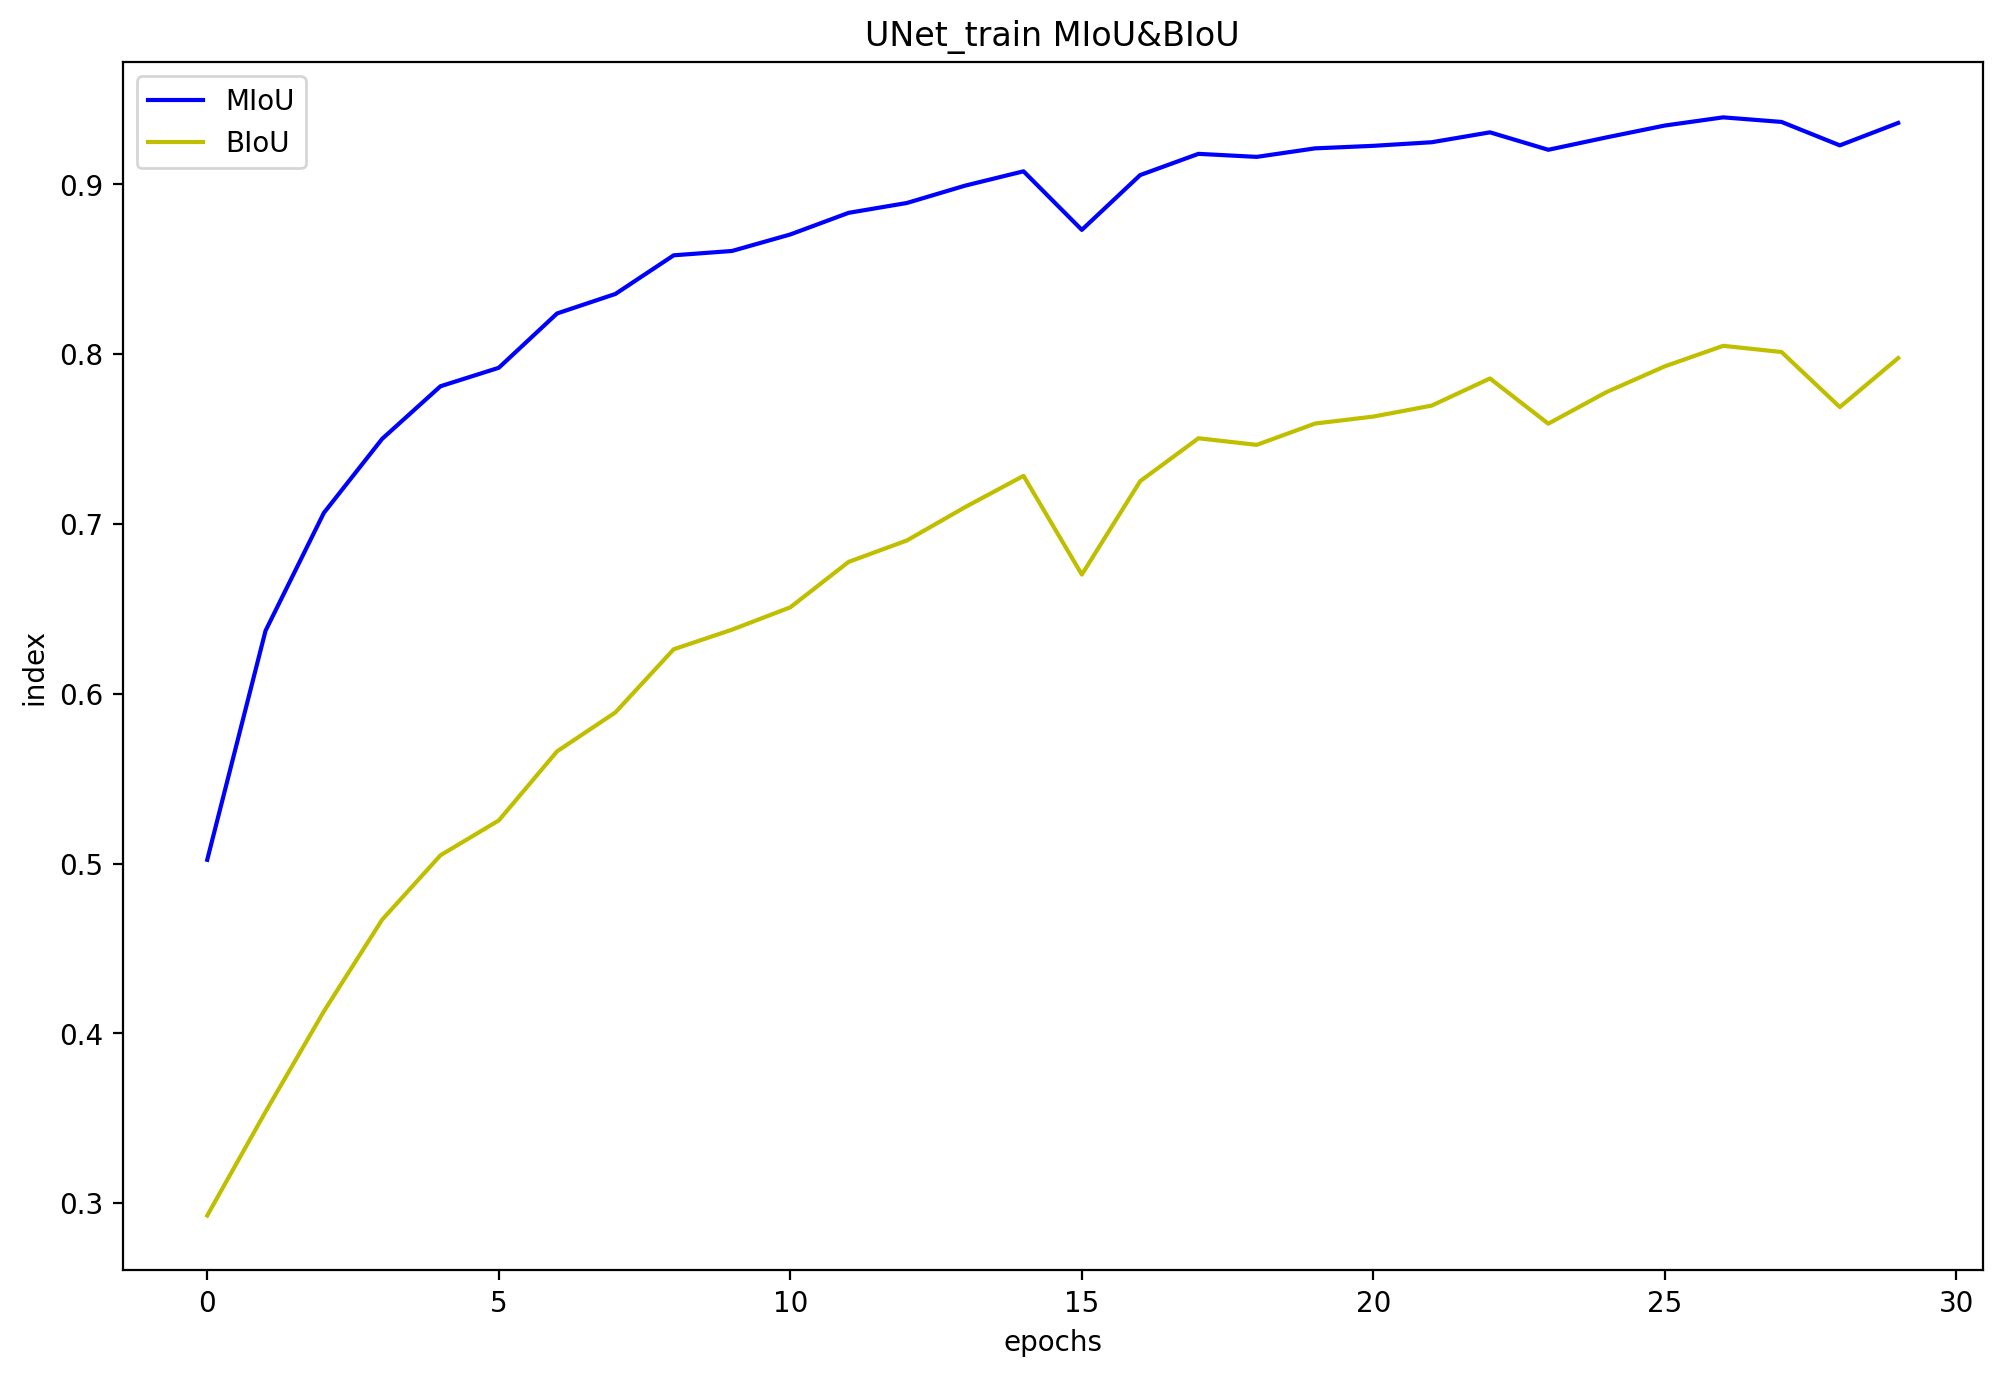

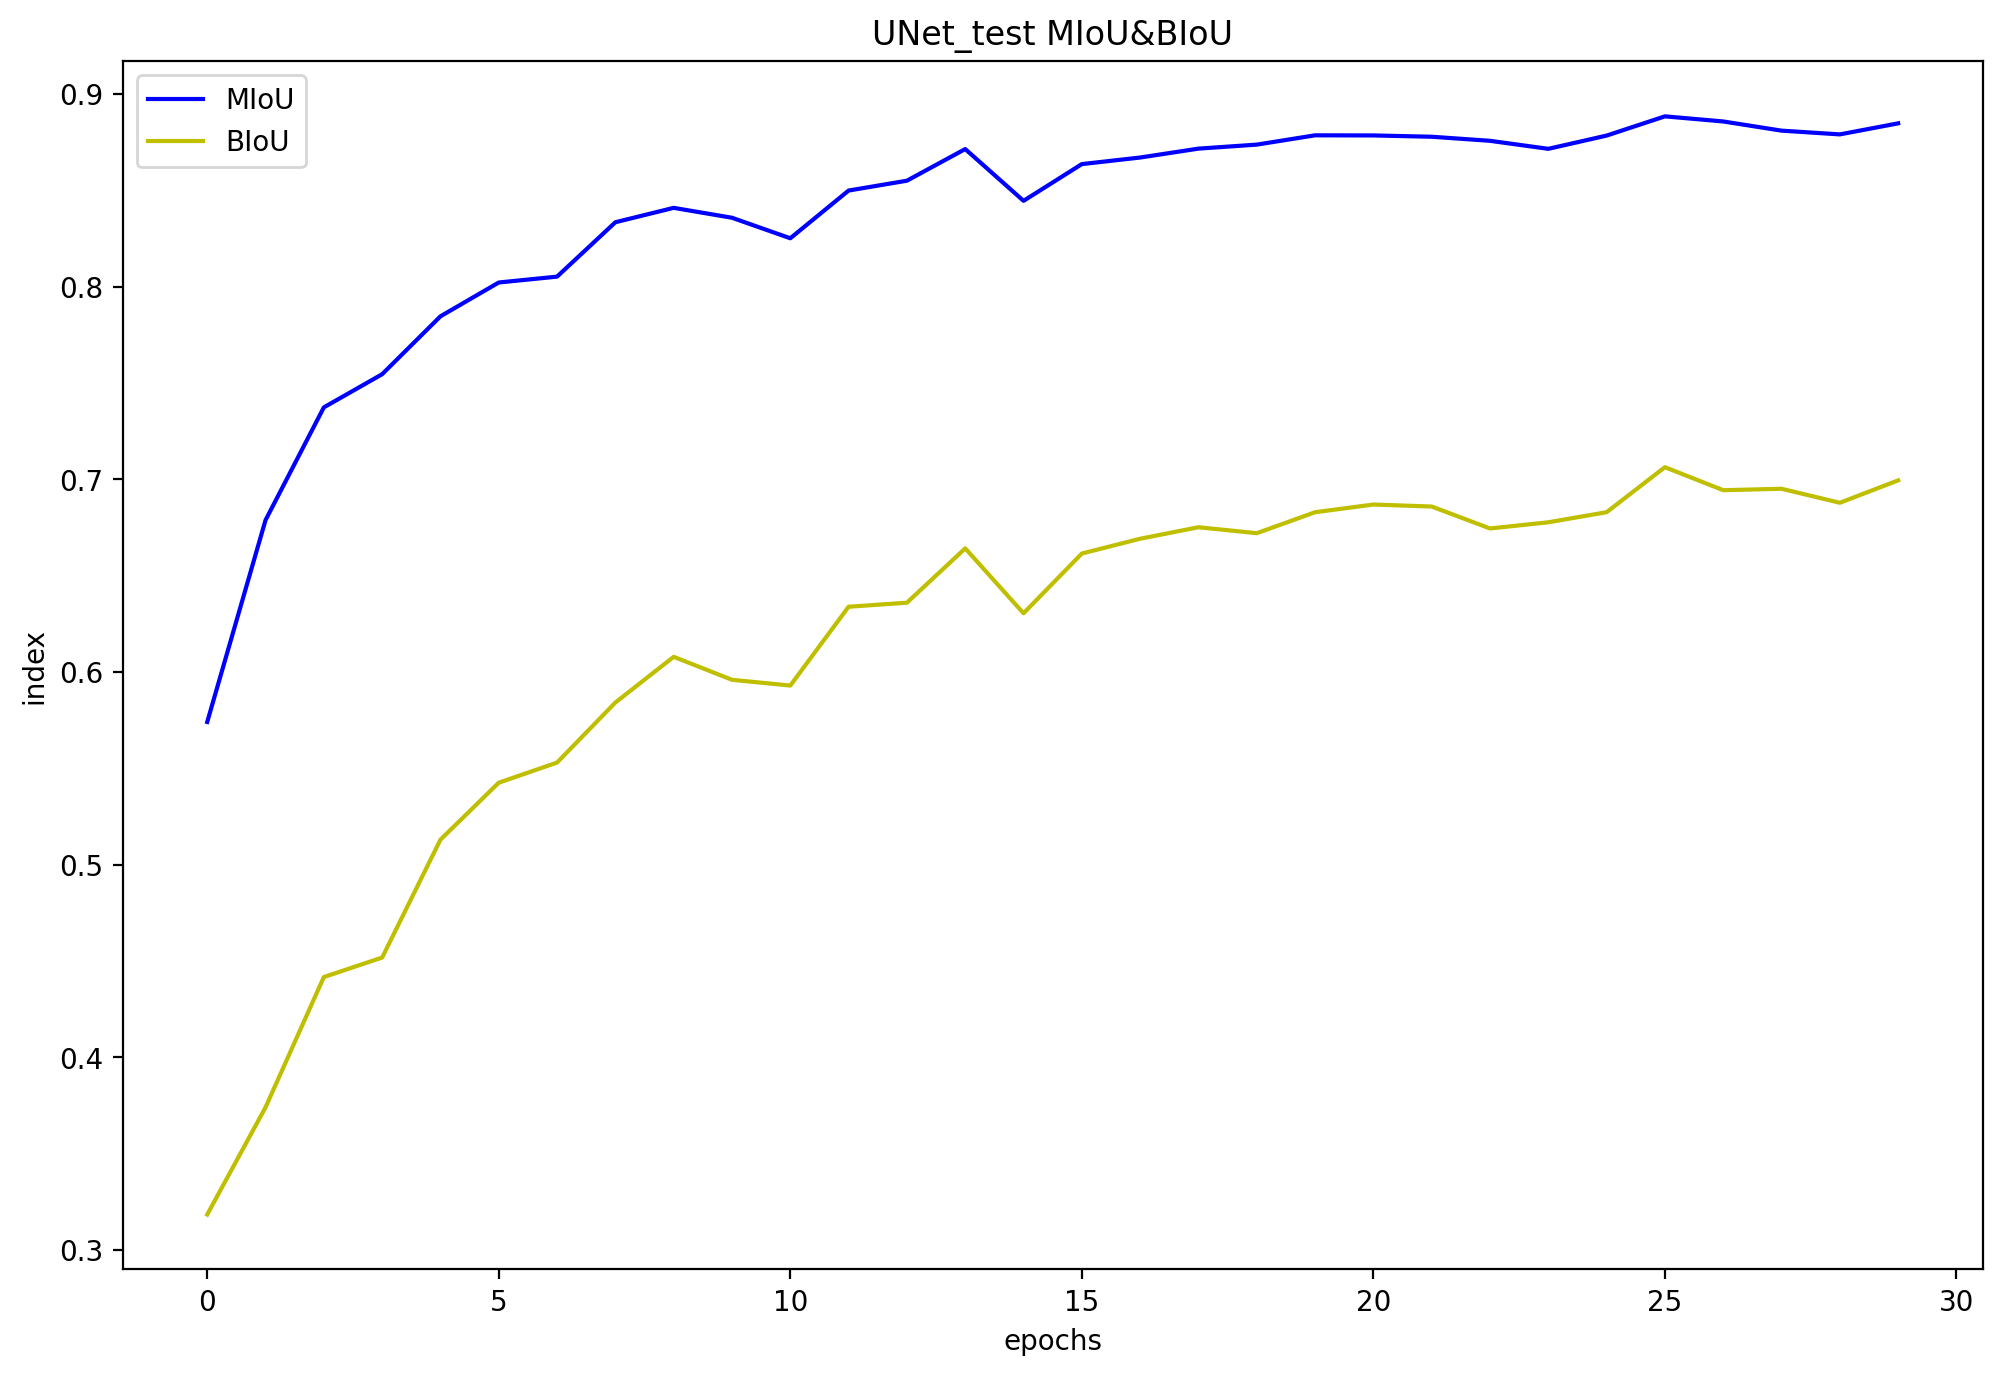

In [18]:
plt.figure(figsize=(12,8), dpi=200)
plt.xlabel('epochs')
plt.ylabel('index')
plt.title('UNet_train MIoU&BIoU')
plt.plot(range(len(miou)),miou,color='b',label='MIoU')
plt.plot(range(len(biou)),biou,color='y',label='BIoU')
plt.legend()
plt.savefig('UNet_train')

plt.figure(figsize=(12,8), dpi=200)
plt.xlabel('epochs')
plt.ylabel('index')
plt.title('UNet_test MIoU&BIoU')
plt.plot(range(len(tmiou)),tmiou,color='b',label='MIoU')
plt.plot(range(len(tbiou)),tbiou,color='y',label='BIoU')
plt.legend()
plt.savefig('UNet_test')

In [8]:
y.shape,image.shape,label.shape

(torch.Size([5, 2, 224, 224]),
 torch.Size([5, 3, 224, 224]),
 torch.Size([5, 224, 224]))

(2, 224, 224) (3, 224, 224) (224, 224)
(224, 224)


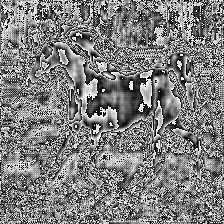

In [14]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
v1=y[2].cpu().detach().numpy()
v2=image[2].cpu().detach().numpy()
v3=label[2].cpu().detach().numpy()
print(v1.shape,v2.shape,v3.shape)
def toimg_RGB(v1):
    nimg = v1.transpose(1,2,0)
    print(nimg.shape)
    img = nimg * 255 # 将原来tensor里0-1的数值乘以255
    img=Image.fromarray(np.uint8(img))
    return img
def toimg_Gray(v1):
    nimg = v1
    print(nimg.shape)
    img = nimg * 255 
    img=Image.fromarray(np.uint8(img))
    return img
toimg_Gray(v1[0])

(224, 224, 2)


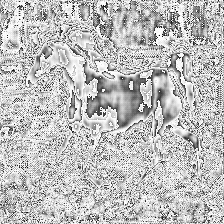

In [17]:
toimg_RGB(v1)

(224, 224)


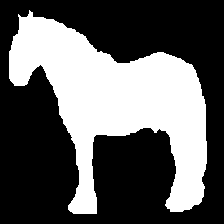

In [11]:
toimg_Gray(v3)

In [12]:
print(tmiou)


[tensor(0.5741), tensor(0.6788), tensor(0.7373), tensor(0.7545), tensor(0.7846), tensor(0.8021), tensor(0.8052), tensor(0.8334), tensor(0.8408), tensor(0.8357), tensor(0.8251), tensor(0.8498), tensor(0.8549), tensor(0.8714), tensor(0.8445), tensor(0.8635), tensor(0.8670), tensor(0.8716), tensor(0.8737), tensor(0.8785), tensor(0.8784), tensor(0.8777), tensor(0.8756), tensor(0.8715), tensor(0.8783), tensor(0.8883), tensor(0.8857), tensor(0.8809), tensor(0.8790), tensor(0.8847)]
